In [4]:
import os
import glob
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm
import time
from scanpy.tools._utils import get_init_pos_from_paga 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import rmm
import cupy
import cudf
import cupy as cp
from rmm.allocators.cupy import rmm_cupy_allocator
import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

from cuml.manifold import UMAP

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [2]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/pseudotime.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 261 ms, sys: 3.24 s, total: 3.51 s
Wall time: 6.7 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

In [3]:
adata.obs[['cluster_phase', 'barcoded_phase']]

,cluster_phase,barcoded_phase
AAACCAAAGGGTAGCA-1,S,G2M
AAACCAAAGTAAGGGT-1,G1,G1
AAACCATTCAGGTAGG-1,G2M,G1
AAACCATTCCAGCCCT-1,G1,S
AAACCATTCGTGACCG-1,G1,G1
...,...,...
TGTGGTCAGCTAACTG-1,G1,G1
TGTGGTCAGTGAGCCT-1,G1,G1
TGTGGTTGTAGCCCTA-1,G1,G1
TGTGGTTGTTGAAGGC-1,G1,G1


\begin{table}
\caption{Confusion matrix: barcoded vs cluster phase}
\label{tab:confusion_matrix}
\begin{tabular}{lrrr}
\toprule
 & G1 & G2M & S \\
\midrule
G1 & 2510 & 950 & 959 \\
G2M & 76 & 746 & 375 \\
S & 273 & 415 & 549 \\
\bottomrule
\end{tabular}
\end{table}



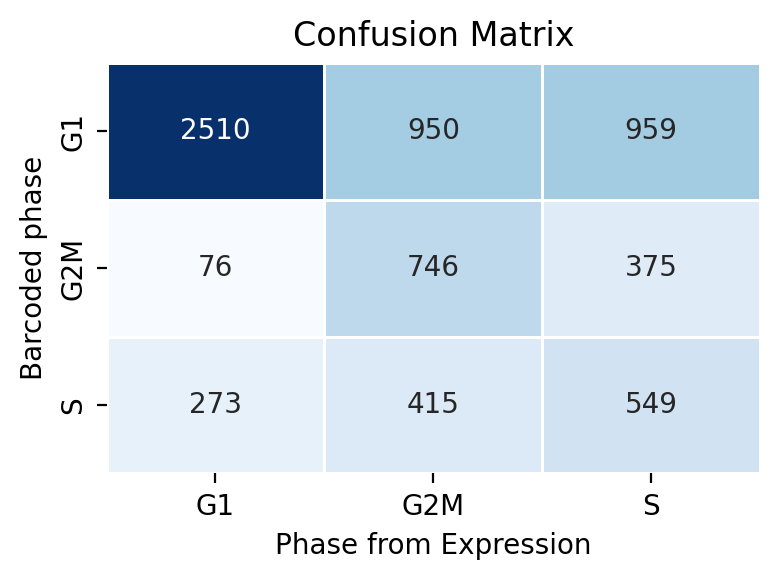

In [11]:
# Extract and drop NaN
y_true = adata.obs['barcoded_phase'].dropna().astype(str)
y_pred = adata.obs.loc[y_true.index, 'cluster_phase'].dropna().astype(str)

# Ensure labels are consistent
labels = sorted(set(y_true) | set(y_pred))

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Convert to DataFrame for LaTeX
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Export to LaTeX
print(cm_df.to_latex(
    escape=False,
    caption="Confusion matrix: barcoded vs cluster phase",
    label="tab:confusion_matrix"
))

# Plot with seaborn
plt.figure(figsize=(4,3), dpi=200)
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d", 
    cmap="Blues", 
    cbar=False,
    lw=1,
)
plt.ylabel("Barcoded phase")
plt.xlabel("Phase from Expression")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

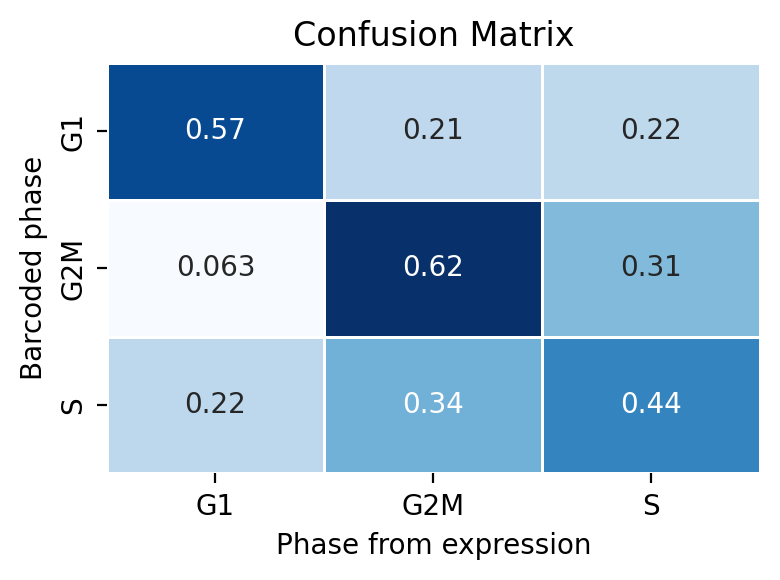

In [15]:
# Normalize row-wise
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, None]

# DataFrame
cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

# Plot with seaborn
plt.figure(figsize=(4,3), dpi=200)
sns.heatmap(
    cm_df,
    annot=True,
    cmap="Blues", 
    cbar=False,
    lw=1,
)
plt.ylabel("Barcoded phase")
plt.xlabel("Phase from expression")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()